# Machine Learning in Julia

An introduction to the
[MLJ](https://alan-turing-institute.github.io/MLJ.jl/stable/)
toolbox.

### Set-up

Inspect Julia version:

In [1]:
VERSION

v"1.6.3"

The following instantiates a package environment.

The package environment has been created using **Julia 1.6** and may not
instantiate properly for other Julia versions.

In [2]:
using Pkg
Pkg.activate("env")
Pkg.instantiate()

  Activating environment at `~/GoogleDrive/Julia/MLJ/MLJTutorial/notebooks/04_tuning/env/Project.toml`
Precompiling project...
  ✓ EvoTrees
  1 dependency successfully precompiled in 11 seconds (203 already precompiled)


## General resources

- [MLJ Cheatsheet](https://alan-turing-institute.github.io/MLJ.jl/dev/mlj_cheatsheet/)
- [Common MLJ Workflows](https://alan-turing-institute.github.io/MLJ.jl/dev/common_mlj_workflows/)
- [MLJ manual](https://alan-turing-institute.github.io/MLJ.jl/dev/)
- [Data Science Tutorials in Julia](https://juliaai.github.io/DataScienceTutorials.jl/)

## Part 4 - Tuning Hyper-parameters

### Naive tuning of a single parameter

The most naive way to tune a single hyper-parameter is to use
`learning_curve`, which we already saw in Part 2. Let's see this in
the Horse Colic classification problem, a case where the parameter
to be tuned is *nested* (because the model is a pipeline).

Here is the Horse Colic data again, with the type coercions we
already discussed in Part 1:

In [3]:
using MLJ
using UrlDownload, CSV, DataFrames
csv_file = urldownload("https://raw.githubusercontent.com/ablaom/"*
                   "MachineLearningInJulia2020/"*
                   "for-MLJ-version-0.16/data/horse.csv");
horse = DataFrames.DataFrame(csv_file); # convert to data frame
coerce!(horse, autotype(horse));
coerce!(horse, Count => Continuous);
coerce!(horse,
        :surgery               => Multiclass,
        :age                   => Multiclass,
        :mucous_membranes      => Multiclass,
        :capillary_refill_time => Multiclass,
        :outcome               => Multiclass,
        :cp_data               => Multiclass);

y, X = unpack(horse, ==(:outcome), name -> true);
schema(X)

┌─────────────────────────┬─────────────────────────────────┬───────────────────
│ _.names                 │ _.types                         │ _.scitypes       ⋯
├─────────────────────────┼─────────────────────────────────┼───────────────────
│ surgery                 │ CategoricalValue{Int64, UInt32} │ Multiclass{2}    ⋯
│ age                     │ CategoricalValue{Int64, UInt32} │ Multiclass{2}    ⋯
│ rectal_temperature      │ Float64                         │ Continuous       ⋯
│ pulse                   │ Float64                         │ Continuous       ⋯
│ respiratory_rate        │ Float64                         │ Continuous       ⋯
│ temperature_extremities │ CategoricalValue{Int64, UInt32} │ OrderedFactor{4} ⋯
│ mucous_membranes        │ CategoricalValue{Int64, UInt32} │ Multiclass{6}    ⋯
│ capillary_refill_time   │ CategoricalValue{Int64, UInt32} │ Multiclass{3}    ⋯
│ pain                    │ CategoricalValue{Int64, UInt32} │ OrderedFactor{5} ⋯
│ peristalsis             │ 

Now for a pipeline model:

In [4]:
LogisticClassifier = @load LogisticClassifier pkg=MLJLinearModels
model = @pipeline Standardizer ContinuousEncoder LogisticClassifier
mach = machine(model, X, y)

[ Info: For silent loading, specify `verbosity=0`. 
import MLJLinearModels ✔


Machine{Pipeline271,…} trained 0 times; caches data
  args: 
    1:	Source @438 ⏎ `ScientificTypesBase.Table{Union{AbstractVector{ScientificTypesBase.Continuous}, AbstractVector{ScientificTypesBase.Multiclass{2}}, AbstractVector{ScientificTypesBase.Multiclass{6}}, AbstractVector{ScientificTypesBase.Multiclass{3}}, AbstractVector{ScientificTypesBase.OrderedFactor{2}}, AbstractVector{ScientificTypesBase.OrderedFactor{4}}, AbstractVector{ScientificTypesBase.OrderedFactor{5}}}}`
    2:	Source @535 ⏎ `AbstractVector{ScientificTypesBase.Multiclass{3}}`


In [5]:
r = range(model, :(logistic_classifier.lambda), lower = 1e-2, upper=100, scale=:log10)

NumericRange(0.01 ≤ logistic_classifier.lambda ≤ 100.0; origin=50.005, unit=49.995) on log10 scale

If you're curious, you can see what `lambda` values this range will
generate for a given resolution:

In [6]:
iterator(r, 5)

5-element Vector{Float64}:
   0.01
   0.1
   1.0
  10.0
 100.0

In [7]:
using Plots
_, _, lambdas, losses = learning_curve(mach,
                                       range=r,
                                       resampling=CV(nfolds=6),
                                       resolution=30, # default
                                       measure=cross_entropy)
plt=plot(lambdas, losses, xscale=:log10)
xlabel!(plt, "lambda")
ylabel!(plt, "cross entropy using 6-fold CV")
savefig("learning_curve2.png")
plt


best_lambda = lambdas[argmin(losses)]

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
[ Info: Training Machine{ProbabilisticTunedModel{Grid,…},…}.
[ Info: Attempting to evaluate 30 models.
Evaluating over 30 metamodels: 100%[=========================] Time: 0:00:15


5.736152510448679

### Self tuning models

A more sophisticated way to view hyper-parameter tuning (inspired by
MLR) is as a model *wrapper*. The wrapped model is a new model in
its own right and when you fit it, it tunes specified
hyper-parameters of the model being wrapped, before training on all
supplied data. Calling `predict` on the wrapped model is like
calling `predict` on the original model, but with the
hyper-parameters already optimized.

In other words, we can think of the wrapped model as a "self-tuning"
version of the original.

We now create a self-tuning version of the pipeline above, adding a
parameter from the `ContinuousEncoder` to the parameters we want
optimized.

First, let's choose a tuning strategy (from [these
options](https://github.com/juliaai/MLJTuning.jl#what-is-provided-here)). MLJ
supports ordinary `Grid` search (query `?Grid` for
details). However, as the utility of `Grid` search is limited to a
small number of parameters, and as `Grid` searches are demonstrated
elsewhere (see the [resources below](#resources-for-part-4)) we'll
demonstrate `RandomSearch` here:

In [8]:
tuning = RandomSearch(rng=123)

RandomSearch(
    bounded = Distributions.Uniform,
    positive_unbounded = Distributions.Gamma,
    other = Distributions.Normal,
    rng = MersenneTwister(123))

In this strategy each parameter is sampled according to a
pre-specified prior distribution that is fit to the one-dimensional
range object constructed using `range` as before. While one has a
lot of control over the specification of the priors (run
`?RandomSearch` for details) we'll let the algorithm generate these
priors automatically.

#### Unbounded ranges and sampling

In MLJ a range does not have to be bounded. In a `RandomSearch` a
positive unbounded range is sampled using a `Gamma` distribution, by
default:

In [9]:
r = range(model,
          :(logistic_classifier.lambda),
          lower=0,
          origin=6,
          unit=5,
          scale=:log10)

NumericRange(0.0 ≤ logistic_classifier.lambda ≤ Inf; origin=6.0, unit=5.0) on log10 scale

The `scale` in a range makes no in a `RandomSearch` (unless it is a
function) but this will effect later plots but it does effect the
later plots.

Let's see what sampling using a Gamma distribution is going to mean
for this range:

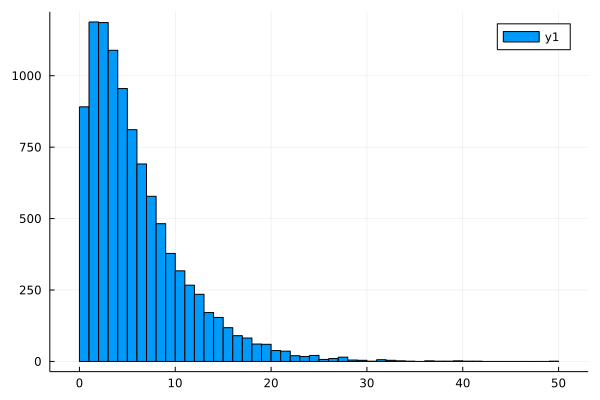

In [10]:
import Distributions
sampler_r = sampler(r, Distributions.Gamma)
plt = histogram(rand(sampler_r, 10000), nbins=50)
savefig("gamma_sampler.png")
plt

The second parameter that we'll add to this is *nominal* (finite) and, by
default, will be sampled uniformly. Since it is nominal, we specify
`values` instead of `upper` and `lower` bounds:

In [11]:
s  = range(model, :(continuous_encoder.one_hot_ordered_factors),
           values = [true, false])

NominalRange(continuous_encoder.one_hot_ordered_factors = true, false)

#### The tuning wrapper

Now for the wrapper, which is an instance of `TunedModel`:

In [12]:
tuned_model = TunedModel(model=model,
                         ranges=[r, s],
                         resampling=CV(nfolds=6),
                         measures=cross_entropy,
                         tuning=tuning,
                         n=15)

ProbabilisticTunedModel(
    model = Pipeline271(
            standardizer = Standardizer,
            continuous_encoder = ContinuousEncoder,
            logistic_classifier = LogisticClassifier),
    tuning = RandomSearch(
            bounded = Distributions.Uniform,
            positive_unbounded = Distributions.Gamma,
            other = Distributions.Normal,
            rng = MersenneTwister(123)),
    resampling = CV(
            nfolds = 6,
            shuffle = false,
            rng = Random._GLOBAL_RNG()),
    measure = LogLoss(tol = 2.220446049250313e-16),
    weights = nothing,
    operation = nothing,
    range = MLJBase.ParamRange[NumericRange(0.0 ≤ logistic_classifier.lambda ≤ Inf; origin=6.0, unit=5.0) on log10 scale, NominalRange(continuous_encoder.one_hot_ordered_factors = true, false)],
    selection_heuristic = MLJTuning.NaiveSelection(nothing),
    train_best = true,
    repeats = 1,
    n = 15,
    acceleration = ComputationalResources.CPU1{Nothing}(nothing),
    

We can apply the `fit!/predict` work-flow to `tuned_model` just as
for any other model:

In [13]:
tuned_mach = machine(tuned_model, X, y);
fit!(tuned_mach);
predict(tuned_mach, rows=1:3)

[ Info: Training Machine{ProbabilisticTunedModel{RandomSearch,…},…}.
[ Info: Attempting to evaluate 15 models.
Evaluating over 15 metamodels: 100%[=========================] Time: 0:00:03


3-element MLJBase.UnivariateFiniteVector{ScientificTypesBase.Multiclass{3}, Int64, UInt32, Float64}:
 UnivariateFinite{ScientificTypesBase.Multiclass{3}}(1=>0.631, 2=>0.22, 3=>0.149)
 UnivariateFinite{ScientificTypesBase.Multiclass{3}}(1=>0.844, 2=>0.00889, 3=>0.147)
 UnivariateFinite{ScientificTypesBase.Multiclass{3}}(1=>0.967, 2=>0.0128, 3=>0.0199)

The outcomes of the tuning can be inspected from a detailed
report. For example, we have:

In [14]:
rep = report(tuned_mach);
rep.best_model

Pipeline271(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = true),
    logistic_classifier = LogisticClassifier(
            lambda = 5.100906526305173,
            gamma = 0.0,
            penalty = :l2,
            fit_intercept = true,
            penalize_intercept = false,
            solver = nothing))

By default, sampling of a bounded range is uniform. Lets

In the special case of two-parameters, you can also plot the results:

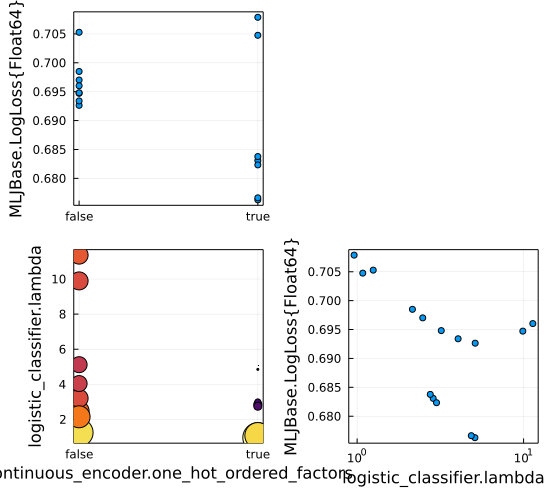

In [15]:
plt = plot(tuned_mach)
savefig("tuning.png")
plt

Finally, let's compare cross-validation estimate of the performance
of the self-tuning model with that of the original model (an example
of [*nested
resampling*]((https://mlr.mlr-org.com/articles/tutorial/nested_resampling.html)
here):

In [16]:
err = evaluate!(mach, resampling=CV(nfolds=3), measure=cross_entropy)

Evaluating over 3 folds: 100%[=========================] Time: 0:00:00


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬────────────────────────
│ measure                    │ measurement │ operation │ per_fold              ⋯
├────────────────────────────┼─────────────┼───────────┼────────────────────────
│ LogLoss(tol = 2.22045e-16) │ 0.736       │ predict   │ [0.759, 0.707, 0.741] ⋯
└────────────────────────────┴─────────────┴───────────┴────────────────────────


In [17]:
tuned_err = evaluate!(tuned_mach, resampling=CV(nfolds=3), measure=cross_entropy)

Evaluating over 3 folds: 100%[=========================] Time: 0:00:06


PerformanceEvaluation object with these fields:
  measure, measurement, operation, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_pairs
Extract:
┌────────────────────────────┬─────────────┬───────────┬────────────────────────
│ measure                    │ measurement │ operation │ per_fold              ⋯
├────────────────────────────┼─────────────┼───────────┼────────────────────────
│ LogLoss(tol = 2.22045e-16) │ 0.705       │ predict   │ [0.717, 0.701, 0.697] ⋯
└────────────────────────────┴─────────────┴───────────┴────────────────────────


<a id='resources-for-part-4'></a>

### Resources for Part 4

- From the MLJ manual:
   - [Learning Curves](https://alan-turing-institute.github.io/MLJ.jl/dev/learning_curves/)
   - [Tuning Models](https://alan-turing-institute.github.io/MLJ.jl/dev/tuning_models/)
- The [MLJTuning repo](https://github.com/juliaai/MLJTuning.jl#who-is-this-repo-for) - mostly for developers

- From Data Science Tutorials:
    - [Tuning a model](https://juliaai.github.io/DataScienceTutorials.jl/getting-started/model-tuning/)
    - [Crabs with XGBoost](https://juliaai.github.io/DataScienceTutorials.jl/end-to-end/crabs-xgb/) `Grid` tuning in stages for a tree-boosting model with many parameters
    - [Boston with LightGBM](https://juliaai.github.io/DataScienceTutorials.jl/end-to-end/boston-lgbm/) -  `Grid` tuning for another popular tree-booster
    - [Boston with Flux](https://juliaai.github.io/DataScienceTutorials.jl/end-to-end/boston-flux/) - optimizing batch size in a simple neural network regressor
- [UCI Horse Colic Data Set](http://archive.ics.uci.edu/ml/datasets/Horse+Colic)

### Exercises for Part 4

#### Exercise 8

This exercise continues our analysis of the King County House price
prediction problem (Part 1, Exercise 3 and Part 2):

In [18]:
house_csv = urldownload("https://raw.githubusercontent.com/ablaom/"*
                        "MachineLearningInJulia2020/for-MLJ-version-0.16/"*
                        "data/house.csv");
house = DataFrames.DataFrame(house_csv)
coerce!(house, autotype(house_csv));
coerce!(house, Count => Continuous, :zipcode => Multiclass);
y, X = unpack(house, ==(:price), name -> true, rng=123);
schema(X)

┌───────────────┬───────────────────────────────────┬───────────────────┐
│ _.names       │ _.types                           │ _.scitypes        │
├───────────────┼───────────────────────────────────┼───────────────────┤
│ bedrooms      │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{13} │
│ bathrooms     │ CategoricalValue{Float64, UInt32} │ OrderedFactor{30} │
│ sqft_living   │ Float64                           │ Continuous        │
│ sqft_lot      │ Float64                           │ Continuous        │
│ floors        │ CategoricalValue{Float64, UInt32} │ OrderedFactor{6}  │
│ waterfront    │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{2}  │
│ view          │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{5}  │
│ condition     │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{5}  │
│ grade         │ CategoricalValue{Int64, UInt32}   │ OrderedFactor{12} │
│ sqft_above    │ Float64                           │ Continuous        │
│ sqft_basement │ Float64             

Your task will be to tune the following pipeline regression model,
which includes a gradient tree boosting component:

In [19]:
EvoTreeRegressor = @load EvoTreeRegressor
tree_booster = EvoTreeRegressor(nrounds = 70)
model = @pipeline ContinuousEncoder tree_booster

[ Info: For silent loading, specify `verbosity=0`. 
import EvoTrees ✔


Pipeline286(
    continuous_encoder = ContinuousEncoder(
            drop_last = false,
            one_hot_ordered_factors = false),
    evo_tree_regressor = EvoTreeRegressor(
            loss = EvoTrees.Linear(),
            nrounds = 70,
            λ = 0.0,
            γ = 0.0,
            η = 0.1,
            max_depth = 5,
            min_weight = 1.0,
            rowsample = 1.0,
            colsample = 1.0,
            nbins = 64,
            α = 0.5,
            metric = :mse,
            rng = MersenneTwister(123),
            device = "cpu"))

(a) Construct a bounded range `r1` for the `evo_tree_booster`
parameter `max_depth`, varying between 1 and 12.

\star&(b) For the `nbins` parameter of the `EvoTreeRegressor`, define the range

In [20]:
r2 = range(model,
           :(evo_tree_regressor.nbins),
           lower = 2.5,
           upper= 7.5, scale=x->2^round(Int, x))

transformed NumericRange(2.5 ≤ evo_tree_regressor.nbins ≤ 7.5; origin=5.0, unit=2.5)

Notice that in this case we've specified a *function* instead of a
canned scale, like `:log10`. In this case the `scale` function is
applied after sampling (uniformly) between the limits of `lower` and
`upper`. Perhaps you can guess the outputs of the following lines of
code?

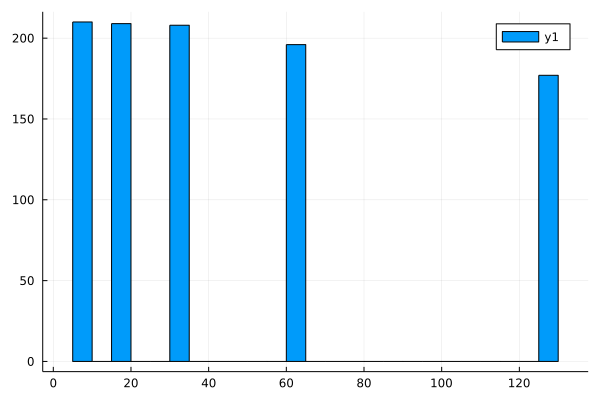

In [21]:
r2_sampler = sampler(r2, Distributions.Uniform)
samples = rand(r2_sampler, 1000);
plt = histogram(samples, nbins=50)
savefig("uniform_sampler.png")

plt

![](uniform_sampler.png)

In [22]:
sort(unique(samples))

5-element Vector{Int64}:
   8
  16
  32
  64
 128

(c) Optimize `model` over these the parameter ranges `r1` and `r2`
using a random search with uniform priors (the default). Use
`Holdout()` resampling, and implement your search by first
constructing a "self-tuning" wrap of `model`, as described
above. Make `mae` (mean absolute error) the loss function that you
optimize, and search over a total of 40 combinations of
hyper-parameters.  If you have time, plot the results of your
search. Feel free to use all available data.

(d) Evaluate the best model found in the search using 3-fold
cross-validation and compare with that of the self-tuning model
(which is different!). Setting data hygiene concerns aside, feel
free to use all available data.

<a id='part-5-advanced-model-composition'>

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*